# Comparison of Estimators

In [1]:
import bisect

def turnbull(data, interval_length = float('inf'), bins = [], low_price = 0, high_price = -1, num_bins = 200, epsilon = 0.01):
    if not bins:
        if high_price == -1:
            high_price = max([k[0] for k in data])
        
        bins = [low_price]
        bin_width = (high_price - low_price) / num_bins
        for _ in range(num_bins - 1):
            bins.append(bins[-1] + bin_width)
        bins = bins[1:]
    else:
        num_bins = len(bins) + 1
        low_price = bins[0] * 2 - bins[1]
        high_price = bins[-1] * 2 - bins[-2]

    if len(data) == 0:
        x = [bins[0] * 2 - bins[1]] + bins
        return x, [0] * num_bins

    intervals = []
    for price, win in data:
        intervals.append((max(price - interval_length, low_price), price) if win else (price, min(price + interval_length, high_price)))
    
    alpha = []
    for left, right in intervals:
        left_idx = bisect.bisect_left(bins, left)
        right_idx = bisect.bisect_left(bins, right)
        alpha.append([left_idx, right_idx])

    density = [1 / num_bins for _ in range(num_bins)]
    diff = float('inf')
    n, m = len(data), num_bins
    while diff > epsilon:
        denominators = []
        for i in range(n):
            denominators.append(sum([density[j] for j in range(alpha[i][0], alpha[i][1] + 1)]))
        
        newdensity = [0] * num_bins
        for i in range(n):
            if denominators[i] != 0:
                for j in range(alpha[i][0], alpha[i][1] + 1):
                    newdensity[j] += density[j] / denominators[i]
        for j in range(m):
            newdensity[j] /= n

        diff = sum([abs(newdensity[j] - density[j]) for j in range(m)])
        density = newdensity

    x = [bins[0] * 2 - bins[1]] + bins
    dist = [density[0]]
    for k in density[1:]:
        dist.append(dist[-1] + k)

    return x, dist

2624
4.1133168175515245


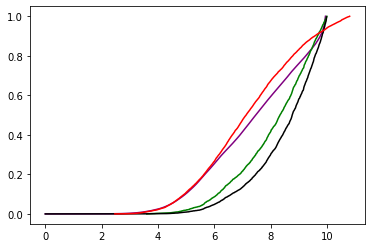

In [3]:
import random
import math
import matplotlib.pyplot as plt
%matplotlib inline

mu, sigma = 2, 0.3
second_data = [random.lognormvariate(mu, sigma) for _ in range(10000)]
sorted_second_data = sorted(second_data)
censored_data = [[random.random() * 10, 0] for _ in range(len(second_data))]
# censored_data = [[random.expovariate(0.4), 0] for _ in range(len(second_data))]
# censored_data = [[random.randint(1, 4) * random.random(), 0] for _ in range(len(second_data))]
# censored_data = [[random.choice([1] * 20 + [4, 11]) + random.random(), 0] for _ in range(len(second_data))]
# censored_data = [[random.lognormvariate(1.5, 0.7), 0] for _ in range(len(second_data))]
true_data = []
for i in range(len(second_data)):
    if second_data[i] < censored_data[i][0]:
        true_data.append(censored_data[i][0])
        censored_data[i][1] = 1
    else:
        true_data.append(second_data[i])
        
tmp = sorted(censored_data)
loseprob = [1]
ni = len(tmp)
for i in range(len(tmp)):
    if tmp[i][1]:
        loseprob.append(loseprob[-1] * (1 - 1 / ni))
    else:
        loseprob.append(loseprob[-1])
    ni -= 1
winprob = [1 - k for k in loseprob]
winprob = winprob[1:]

winevent = []
loseevent = []
for k in censored_data:
    if k[1]:
        winevent.append(k[0])
    else:
        loseevent.append(k[0])
print(len(winevent))
wldiff = sum(winevent) / len(winevent) - sum(loseevent) / len(loseevent)
print(wldiff)

num_this_price_bins = 1000
min_price = min([k[0] for k in censored_data])
max_price = max([k[0] for k in censored_data])
bin_width = (max_price - min_price) / num_this_price_bins
this_price_bins = [min_price + bin_width]
for _ in range(1, num_this_price_bins - 1):
    this_price_bins.append(this_price_bins[-1] + bin_width)

def kme(data, gap = -1):
    count = [[0, 0] for _ in range(num_this_price_bins)]
    for p, k in data:
        pos = bisect.bisect_left(this_price_bins, p)
        count[pos][0] += k
        count[pos][1] += 1 - k
    loseprob = [1]
    ni = len(data)
    for i in range(len(count)):
        di = count[i][0]
        if gap != -1:
            if i >= gap:
                di += count[i - gap][1] * 0.5
                ni += count[i - gap][1]
        if i > 1:
            ni -= count[i - 2][1]
        if i:
            ni -= count[i - 1][0]
        if ni != 0:
            loseprob.append(loseprob[-1] * (1 - di / ni))
        else:
            loseprob.append(loseprob[-1])
        if gap != -1:
            if i >= gap:
                ni -= count[i - gap][1]
    winprob = [1 - k for k in loseprob]
    return winprob[1:]

def binprob(data):
    count = [[0, 0] for _ in range(num_this_price_bins)]
    for p, k in data:
        pos = bisect.bisect_left(this_price_bins, p)
        count[pos][0] += k
        count[pos][1] += 1 - k
    winprob = [0]
    for i, j in count:
        if i + j == 0:
            winprob.append(winprob[-1])
        else:
            winprob.append(max(winprob[-1], i / (i + j)))
    return winprob[1:]

x = [2 * this_price_bins[0] - this_price_bins[1]] + this_price_bins
# plt.plot(x, kme(censored_data, gap = int(wldiff / bin_width)), 'yellow')
# plt.plot(x, binprob(censored_data), 'orange')

xx, dist = turnbull(censored_data, epsilon = 0.01, interval_length = float('inf'))
plt.plot(xx, dist, 'purple')

sorted_second_data = sorted(second_data)
sorted_true_data = sorted(true_data)
sorted_winevent = sorted(winevent)
sorted_true_data = sorted_true_data[:9000]
sorted_second_data = sorted_second_data[:9000]
plt.plot(sorted_winevent, [k / len(sorted_winevent) for k in range(len(sorted_winevent))], 'green')
# plt.plot(sorted_true_data, [k / len(sorted_true_data) for k in range(len(sorted_true_data))], 'blue')
# plt.plot([k[0] for k in tmp], winprob, 'black')
plt.plot(x, kme(censored_data), 'black')
plt.plot(sorted_second_data, [k / len(sorted_second_data) for k in range(len(sorted_second_data))], 'red')

2539
2.256427446405744


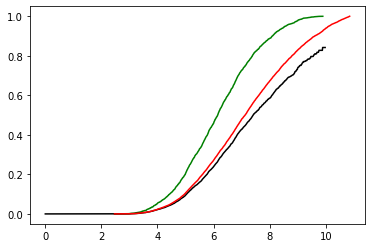

In [4]:
import random
import math
import matplotlib.pyplot as plt
%matplotlib inline

mu, sigma = 2, 0.3
second_data = [random.lognormvariate(mu, sigma) for _ in range(10000)]
sorted_second_data = sorted(second_data)
censored_data = [[random.random() * 10, 0] for _ in range(len(second_data))]
# censored_data = [[random.expovariate(0.4), 0] for _ in range(len(second_data))]
# censored_data = [[random.randint(1, 4) * random.random(), 0] for _ in range(len(second_data))]
# censored_data = [[random.choice([1] * 20 + [4, 11]) + random.random(), 0] for _ in range(len(second_data))]
# censored_data = [[random.lognormvariate(1.5, 0.7), 0] for _ in range(len(second_data))]
true_data = []
for i in range(len(second_data)):
    if second_data[i] < censored_data[i][0]:
        true_data.append(censored_data[i][0])
        censored_data[i][1] = 1
        censored_data[i][0] = second_data[i]
    else:
        true_data.append(second_data[i])
        
tmp = sorted(censored_data)
loseprob = [1]
ni = len(tmp)
for i in range(len(tmp)):
    if tmp[i][1]:
        loseprob.append(loseprob[-1] * (1 - 1 / ni))
    else:
        loseprob.append(loseprob[-1])
    ni -= 1
winprob = [1 - k for k in loseprob]
winprob = winprob[1:]

winevent = []
loseevent = []
for k in censored_data:
    if k[1]:
        winevent.append(k[0])
    else:
        loseevent.append(k[0])
print(len(winevent))
wldiff = sum(winevent) / len(winevent) - sum(loseevent) / len(loseevent)
print(wldiff)

num_this_price_bins = 1000
min_price = min([k[0] for k in censored_data])
max_price = max([k[0] for k in censored_data])
bin_width = (max_price - min_price) / num_this_price_bins
this_price_bins = [min_price + bin_width]
for _ in range(1, num_this_price_bins - 1):
    this_price_bins.append(this_price_bins[-1] + bin_width)

def kme(data, gap = -1):
    count = [[0, 0] for _ in range(num_this_price_bins)]
    for p, k in data:
        pos = bisect.bisect_left(this_price_bins, p)
        count[pos][0] += k
        count[pos][1] += 1 - k
    loseprob = [1]
    ni = len(data)
    for i in range(len(count)):
        di = count[i][0]
        if gap != -1:
            if i >= gap:
                di += count[i - gap][1] * 0.5
                ni += count[i - gap][1]
        if i > 1:
            ni -= count[i - 2][1]
        if i:
            ni -= count[i - 1][0]
        if ni != 0:
            loseprob.append(loseprob[-1] * (1 - di / ni))
        else:
            loseprob.append(loseprob[-1])
        if gap != -1:
            if i >= gap:
                ni -= count[i - gap][1]
    winprob = [1 - k for k in loseprob]
    return winprob[1:]

def binprob(data):
    count = [[0, 0] for _ in range(num_this_price_bins)]
    for p, k in data:
        pos = bisect.bisect_left(this_price_bins, p)
        count[pos][0] += k
        count[pos][1] += 1 - k
    winprob = [0]
    for i, j in count:
        if i + j == 0:
            winprob.append(winprob[-1])
        else:
            winprob.append(max(winprob[-1], i / (i + j)))
    return winprob[1:]

x = [2 * this_price_bins[0] - this_price_bins[1]] + this_price_bins
# plt.plot(x, kme(censored_data, gap = int(wldiff / bin_width)), 'yellow')
# plt.plot(x, binprob(censored_data), 'orange')

# xx, dist = turnbull(censored_data, epsilon = 0.01, interval_length = float('inf'))
# plt.plot(xx, dist, 'purple')

sorted_second_data = sorted(second_data)
sorted_true_data = sorted(true_data)
sorted_winevent = sorted(winevent)
sorted_true_data = sorted_true_data[:9000]
sorted_second_data = sorted_second_data[:9000]
plt.plot(sorted_winevent, [k / len(sorted_winevent) for k in range(len(sorted_winevent))], 'green')
# plt.plot(sorted_true_data, [k / len(sorted_true_data) for k in range(len(sorted_true_data))], 'blue')
# plt.plot([k[0] for k in tmp], winprob, 'black')
plt.plot(x, kme(censored_data), 'black')
plt.plot(sorted_second_data, [k / len(sorted_second_data) for k in range(len(sorted_second_data))], 'red')